# Taking out cells

In [290]:
import sys
import os as os
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle as pkl

import scipy as scipy
import scipy.io as spio
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.io.matlab import mat_struct
import pickle
import random
random.seed(666)

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=True, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], scipy.io.matlab.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

## Load session data

In [291]:
meta = {}
meta[45] = {'mouse':'3C280', 'ks':'Kilosort_2024-04-12_162032', 'del_units':[594], 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[46] = {'mouse':'3C280', 'ks':'Kilosort_2024-04-12_180855', 'del_units':None, 'vis_mice':np.array(['nan', 'alpha', 'beta'])}
meta[11] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-06_154258', 'del_units':[847, 835], 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[13] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-14_120055', 'del_units':None, 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[14] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-14_122629', 'del_units':None, 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[19] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-14_140410', 'del_units':None, 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[20] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-15_110539', 'del_units':[33], 'vis_mice':np.array(['nan', 'beta', 'alpha'])}

In [292]:
Session = 20

In [293]:
mouse = meta[Session]['mouse']
ks = meta[Session]['ks']
del_units=meta[Session]['del_units']
vis_mice = meta[Session]['vis_mice']
active_blocks = [1,2,3]


In [294]:
a_idx = np.where(vis_mice=='alpha')[0][0]
b_idx = np.where(vis_mice=='beta')[0][0]
c_idx = 3 

In [295]:
# create folder to save results
try:
    os.makedirs(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\taking_out_analysis')
except:
    pass

In [296]:
# create folder to save results
try:
    os.makedirs(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\taking_out_analysis\\S{Session}')
except:
    pass

### Ephys data

In [297]:
KSdir = f'L:\\everyone\\sharedDATA\\ProcessedDATA\\{mouse}\\{mouse}_S{Session}\\{ks}\\'

spiketimesfile = KSdir+"spike_times.npy"  
spiketimes = np.load(spiketimesfile)  #### all spiketimes as indexes regardless of cluster

clusterfile = KSdir+"spike_clusters.npy"
spikeclusters = np.load(clusterfile) #### cluster id for each detected spike

Clusterinfofile = KSdir+"cluster_info.tsv"
Clusterinfo = pd.read_csv(Clusterinfofile,sep='\t') #### cluster meta-data matrix

In [298]:
goodclusts = Clusterinfo['cluster_id'][np.where(Clusterinfo['group']=='good')[0]]
goods = []
for clust in goodclusts :
    goods.append(clust)
print(f'Session {Session}: {len(goods)} good clusters')

Session 20: 17 good clusters


In [299]:
goodspiketimes = {}

spikethresh = 1000 # min nb of spikes
for goodunit in goods :
    goodinds = np.where(spikeclusters==goodunit)[0]
    if goodinds.shape[0] > spikethresh : 
        goodspiketimes[goodunit] = spiketimes[goodinds]

In [300]:
len(goodspiketimes.keys())

17

### Behavior data

In [301]:
matfile =  f'L:\\everyone\\sharedDATA\\ProcessedDATA\\{mouse}\\{mouse}_S{Session}\\Behaviour.mat'
EvaBehavior = loadmat(matfile)

In [302]:
def load_behavioral_event(event_idx, time_to_idx = True):
    '''
    returns dictionary; keys - blocks; inside - array with event :
    time stamps in [sec] if time_to_idx = False
    indexes if time_to_idx = True
    '''
    event_dic = {}

    for block in np.arange(EvaBehavior['Behaviour'].shape[0]) :
        if time_to_idx:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]*20000
        else:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]
        event_dic[block] = event_dic[block].astype(int)
    
    return event_dic

In [303]:
TestSocialSampleWindowPerTrial = load_behavioral_event(12) 

### Firing rates

In [304]:
import copy

In [305]:
def fr_matrix_prep(beforesamples, aftersamples, blocks, bins, del_units=None):
    # discard wierd cells based on rasters
    goodspiketimes_copy = copy.deepcopy(goodspiketimes)

    try:
        for unit in del_units:
            del goodspiketimes_copy[unit]
    except:
        pass

    units = goodspiketimes_copy.keys()
    fr_dic = {}
   
    for block in blocks:
        n_trials = TestSocialSampleWindowPerTrial[block].shape[0]
        n_units = len(goodspiketimes_copy.keys())

        fr_matrix = np.zeros((n_trials, n_units))

        i = 0
        for unit in units: # list of good cluster_id
            
            
            for event in np.arange(TestSocialSampleWindowPerTrial[block].shape[0]) : #iterate by npoke events

                onset = TestSocialSampleWindowPerTrial[block][event,0]
                offset = TestSocialSampleWindowPerTrial[block][event,1]
                
                cond1 = np.where(goodspiketimes_copy[unit].astype(int)>=onset-beforesamples)[0]
                cond2 = np.where(goodspiketimes_copy[unit].astype(int)<=offset+aftersamples)[0]
                unitspikes = goodspiketimes_copy[unit][np.intersect1d(cond1,cond2)].astype(int)-onset

                n = np.histogram(unitspikes, bins=bins)[0][0]
                fr = n/0.25
                fr_matrix[event, i] = fr
            i+=1
                
        fr_dic[block] = fr_matrix
    
    return fr_dic

In [306]:
## find spikes in interesting behavioral window
samplplimg_rate = 20*1000 #20 kHz
beforesamples = 0*samplplimg_rate # 1 sec (expressed in samples for a 20khz sampling rate)
aftersamples = 0*samplplimg_rate # 1 sec
npoke_window = 0.25
eventlength = npoke_window*samplplimg_rate # 0.25 s

binsize = 0.25*samplplimg_rate 
bins = np.linspace(-beforesamples,aftersamples+eventlength,int((beforesamples+aftersamples+eventlength)/binsize)+1)

In [307]:
# 250 ms during the nosepoke
firing_rates_dic = fr_matrix_prep(beforesamples, aftersamples, blocks=[1,2,3], bins=bins, del_units=del_units)

In [308]:
firing_rates_dic[a_idx].shape

(30, 16)

## Classifiers

In [309]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from scipy.stats import percentileofscore
from sklearn.preprocessing import StandardScaler
import random

In [310]:
def SVM(alpha_data, beta_data, kernel = 'linear', cv=5):

    # params
    num_rows = alpha_data.shape[0]
    indices = list(range(num_rows))
    train_proportion = 6 # out of 30 trials

    # collect outcomes
    accuracy_cv5 = []

    for n in range(cv):
        test_alpha_idx = random.sample(indices, train_proportion)
        train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
        test_alpha = alpha_data[test_alpha_idx]
        train_alpha = alpha_data[train_alpha_idx]

        test_beta_idx = random.sample(indices, train_proportion)
        train_beta_idx = [number for number in indices if number not in test_beta_idx]
        test_beta = beta_data[test_beta_idx]
        train_beta = beta_data[train_beta_idx]

        test_ab = np.concatenate((test_alpha,test_beta), axis=0)
        train_ab = np.concatenate((train_alpha,train_beta), axis=0)

        # Standardize the data
        scaler = StandardScaler()
        test_ab = scaler.fit_transform(test_ab)
        train_ab = scaler.fit_transform(train_ab)

        y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
        y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

        # randomize train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab = train_ab[shuffled_indices]
        y_train = y_train[shuffled_indices]

        svm_classifier_cv = SVC(kernel=kernel, random_state=666)
        svm_classifier_cv.fit(train_ab, y_train)
        y_pred = svm_classifier_cv.predict(test_ab)
        accuracy_cv5.append(accuracy_score(y_test, y_pred)) 

    return np.mean(np.array(accuracy_cv5)) 

In [311]:
def bayes(alpha_data, beta_data, cv=5):

    # params
    num_rows = alpha_data.shape[0]
    indices = list(range(num_rows))
    train_proportion = 6 # out of 30 trials

    # collect outcomes
    accuracy_cv5 = []

    for n in range(cv):
        test_alpha_idx = random.sample(indices, train_proportion)
        train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
        test_alpha = alpha_data[test_alpha_idx]
        train_alpha = alpha_data[train_alpha_idx]

        test_beta_idx = random.sample(indices, train_proportion)
        train_beta_idx = [number for number in indices if number not in test_beta_idx]
        test_beta = beta_data[test_beta_idx]
        train_beta = beta_data[train_beta_idx]

        test_ab = np.concatenate((test_alpha,test_beta), axis=0)
        train_ab = np.concatenate((train_alpha,train_beta), axis=0)

        # # Standardize the data
        # scaler = StandardScaler()
        # test_ab = scaler.fit_transform(test_ab)
        # train_ab = scaler.fit_transform(train_ab)

        y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
        y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

        # randomize train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab = train_ab[shuffled_indices]
        y_train = y_train[shuffled_indices]

        bayes_classifier_cv = GaussianNB()
        bayes_classifier_cv.fit(train_ab, y_train)
        y_pred = bayes_classifier_cv.predict(test_ab)
        accuracy_cv5.append(accuracy_score(y_test, y_pred)) 

    return np.mean(np.array(accuracy_cv5)) 

In [312]:
# data prep
alpha_data = firing_rates_dic[a_idx]
beta_data = firing_rates_dic[b_idx]
blank_data = firing_rates_dic[c_idx]

num_rows = alpha_data.shape[0]
shuffled_indices = list(range(num_rows))

random.shuffle(shuffled_indices)
alpha_data = alpha_data[shuffled_indices]

random.shuffle(shuffled_indices)
beta_data = beta_data[shuffled_indices]

num_rows = alpha_data.shape[0]
social_data = np.concatenate((alpha_data[:int(num_rows/2),:], beta_data[int(num_rows/2):,:]), axis=0)

random.shuffle(shuffled_indices)
blank_data = blank_data[shuffled_indices]

alpha_data.shape, beta_data.shape, blank_data.shape, social_data.shape

((30, 16), (30, 16), (30, 16), (30, 16))

### Taking out neurons

In [313]:
n_neurons = firing_rates_dic[a_idx].shape[1]
neurons_idx = np.arange(0,n_neurons,1)
n_neurons, neurons_idx

(16, array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]))

In [314]:
SVM_s_vs_bl = {}
bayes_s_vs_bl = {}

SVM_a_vs_b = {}
bayes_a_vs_b = {}

for n_take in range(n_neurons): # take out from 0 to n-1 neurons

    SVM_sbl = []
    bayes_sbl = []

    SVM_ab = []
    bayes_ab = []

    mew=True
    
    for ch in range(100):
        
        # remove columns (neurons)
        take_idx = random.sample(list(neurons_idx), k=n_take)
        a_matrix = np.delete(alpha_data, take_idx, axis=1)
        b_matrix = np.delete(beta_data, take_idx, axis=1)
        bl_matrix = np.delete(blank_data, take_idx, axis=1)
        s_matrix = np.delete(social_data, take_idx, axis=1)

        if ch<=3:
            print(a_matrix.shape, b_matrix.shape, bl_matrix.shape, s_matrix.shape)

        svm_ab = SVM(a_matrix, b_matrix)
        svm_sbl = SVM(bl_matrix, s_matrix)
        bay_ab = bayes(a_matrix, b_matrix)
        bay_sbl = bayes(bl_matrix, s_matrix)

        SVM_ab.append(svm_ab)
        bayes_ab.append(bay_ab)

        SVM_sbl.append(svm_sbl)
        bayes_sbl.append(bay_sbl)

    SVM_a_vs_b[n_take] = SVM_ab
    bayes_a_vs_b[n_take] = bayes_ab

    SVM_s_vs_bl[n_take] = SVM_sbl
    bayes_s_vs_bl[n_take] = bayes_sbl

(30, 16) (30, 16) (30, 16) (30, 16)
(30, 16) (30, 16) (30, 16) (30, 16)
(30, 16) (30, 16) (30, 16) (30, 16)
(30, 16) (30, 16) (30, 16) (30, 16)
(30, 15) (30, 15) (30, 15) (30, 15)
(30, 15) (30, 15) (30, 15) (30, 15)
(30, 15) (30, 15) (30, 15) (30, 15)
(30, 15) (30, 15) (30, 15) (30, 15)
(30, 14) (30, 14) (30, 14) (30, 14)
(30, 14) (30, 14) (30, 14) (30, 14)
(30, 14) (30, 14) (30, 14) (30, 14)
(30, 14) (30, 14) (30, 14) (30, 14)
(30, 13) (30, 13) (30, 13) (30, 13)
(30, 13) (30, 13) (30, 13) (30, 13)
(30, 13) (30, 13) (30, 13) (30, 13)
(30, 13) (30, 13) (30, 13) (30, 13)
(30, 12) (30, 12) (30, 12) (30, 12)
(30, 12) (30, 12) (30, 12) (30, 12)
(30, 12) (30, 12) (30, 12) (30, 12)
(30, 12) (30, 12) (30, 12) (30, 12)
(30, 11) (30, 11) (30, 11) (30, 11)
(30, 11) (30, 11) (30, 11) (30, 11)
(30, 11) (30, 11) (30, 11) (30, 11)
(30, 11) (30, 11) (30, 11) (30, 11)
(30, 10) (30, 10) (30, 10) (30, 10)
(30, 10) (30, 10) (30, 10) (30, 10)
(30, 10) (30, 10) (30, 10) (30, 10)
(30, 10) (30, 10) (30, 10) (

c:\Users\ebukina\AppData\Local\anaconda3\Lib\site-packages\sklearn\naive_bayes.py:515: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
c:\Users\ebukina\AppData\Local\anaconda3\Lib\site-packages\sklearn\naive_bayes.py:516: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
c:\Users\ebukina\AppData\Local\anaconda3\Lib\site-packages\sklearn\naive_bayes.py:515: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
c:\Users\ebukina\AppData\Local\anaconda3\Lib\site-packages\sklearn\naive_bayes.py:516: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
c:\Users\ebukina\AppData\Local\anaconda3\Lib\site-packages\sklearn\naive_bayes.py:515: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2

In [315]:
keys = ['SVM_sbl', 'bayes_sbl', 'SVM_ab', 'bayes_ab']
takeout_accuracy_dic = {key: None for key in keys}

takeout_accuracy_dic['SVM_sbl'] = SVM_s_vs_bl
takeout_accuracy_dic['bayes_sbl'] = bayes_s_vs_bl

takeout_accuracy_dic['SVM_ab'] = SVM_a_vs_b
takeout_accuracy_dic['bayes_ab'] = bayes_a_vs_b

In [316]:
save_path = f'C:\\Users\\ebukina\\Desktop\\eva\\results\\taking_out_analysis\\S{Session}\\{mouse}_S{Session}_classifiers_results_takeout.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(takeout_accuracy_dic, f)

In [317]:
def takeout_plot(dics, dic_names):
    all_means = []
    all_stds = []
    for dic in dics:
        means = []
        stds = []
        for n_take in range(n_neurons):
            means.append(np.mean(np.array(dic[n_take])))
            stds.append(np.std(np.array(dic[n_take])))
        means=np.array(means)
        stds=np.array(stds)
        all_means.append(means)
        all_stds.append(stds)

    colors = ['#800080', '#0000CD', '#FF6347', '#FF69B4']
    plt.figure(figsize=(10,5)) 
    for i in range(len(dics)):
        plt.plot(all_means[i], color=colors[i], alpha=0.8, label=dic_names[i], linewidth=3)
        plt.fill_between(np.arange(len(all_means[i])), all_means[i] - all_stds[i], all_means[i] + all_stds[i], color=colors[i], alpha=0.15)
    plt.xlabel('Number of taken out neurons',  fontsize=12)
    plt.ylabel('Accuracy',  fontsize=12)
    plt.title("Model performance with different numbers of neurons")
    plt.xticks(np.arange(len(means)), labels=np.arange(len(means)), fontsize=10)
    plt.grid(True)
    plt.legend()
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlim(-0.5,n_neurons-0.5)
    plt.ylim(0,1.09)
    plt.tight_layout()
    #plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\populational_analysis\\{mouse}_S{Session}_ED_trialwise_a_vs_b.png', dpi=300, bbox_inches='tight')
    plt.show()

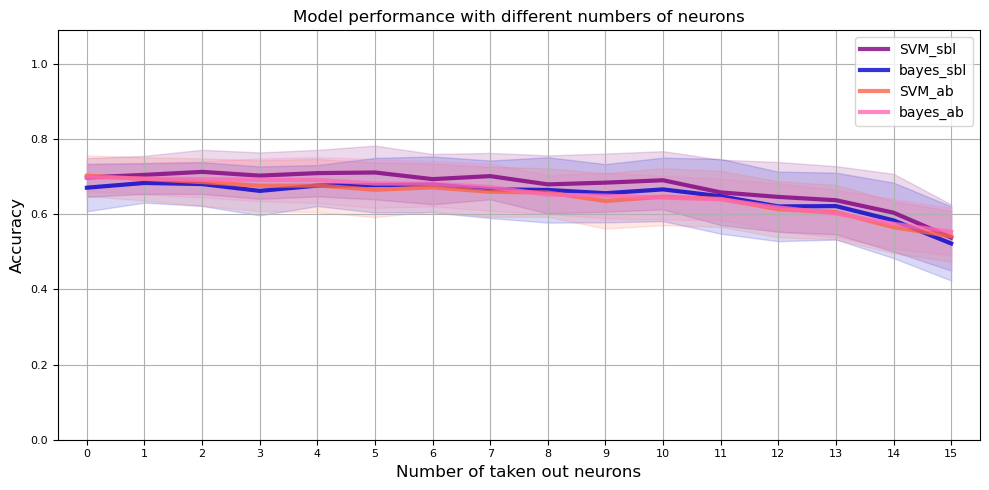

In [318]:
takeout_plot([SVM_s_vs_bl, bayes_s_vs_bl, SVM_a_vs_b, bayes_a_vs_b], 
              ['SVM_sbl', 'bayes_sbl', 'SVM_ab', 'bayes_ab'])

### Taking out trials

In [319]:
n_trials = firing_rates_dic[a_idx].shape[0]
trials_idx = list(np.arange(0,n_trials,1))
trials_idx

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

In [320]:
n_trials

30

In [326]:
tSVM_s_vs_bl = {}
tbayes_s_vs_bl = {}

tSVM_a_vs_b = {}
tbayes_a_vs_b = {}

for n_take in range(n_trials-5): # we need at least 5 trials to split into 80 and 20 %

    SVM_sbl = []
    bayes_sbl = []

    SVM_ab = []
    bayes_ab = []

    mew=True

    for ch in range(100):
        # remove rows (trials)

        take_idx = random.sample(trials_idx, k=n_take)
        a_matrix = np.delete(alpha_data, take_idx, axis=0)
        b_matrix = np.delete(beta_data, take_idx, axis=0)
        bl_matrix = np.delete(blank_data, take_idx, axis=0)
        s_matrix = np.delete(social_data, take_idx, axis=0)
    
        if ch<3:
            print(a_matrix.shape, b_matrix.shape, bl_matrix.shape, s_matrix.shape)

        svm_ab = SVM(a_matrix, b_matrix)
        svm_sbl = SVM(bl_matrix, s_matrix)
        bay_ab = bayes(a_matrix, b_matrix)
        bay_sbl = bayes(bl_matrix, s_matrix)

        SVM_ab.append(svm_ab)
        bayes_ab.append(bay_ab)

        SVM_sbl.append(svm_sbl)
        bayes_sbl.append(bay_sbl)

    tSVM_a_vs_b[n_take] = SVM_ab
    tbayes_a_vs_b[n_take] = bayes_ab

    tSVM_s_vs_bl[n_take] = SVM_sbl
    tbayes_s_vs_bl[n_take] = bayes_sbl

(30, 16) (30, 16) (30, 16) (30, 16)
(30, 16) (30, 16) (30, 16) (30, 16)
(30, 16) (30, 16) (30, 16) (30, 16)
(29, 16) (29, 16) (29, 16) (29, 16)
(29, 16) (29, 16) (29, 16) (29, 16)
(29, 16) (29, 16) (29, 16) (29, 16)
(28, 16) (28, 16) (28, 16) (28, 16)
(28, 16) (28, 16) (28, 16) (28, 16)
(28, 16) (28, 16) (28, 16) (28, 16)
(27, 16) (27, 16) (27, 16) (27, 16)
(27, 16) (27, 16) (27, 16) (27, 16)
(27, 16) (27, 16) (27, 16) (27, 16)
(26, 16) (26, 16) (26, 16) (26, 16)
(26, 16) (26, 16) (26, 16) (26, 16)
(26, 16) (26, 16) (26, 16) (26, 16)
(25, 16) (25, 16) (25, 16) (25, 16)
(25, 16) (25, 16) (25, 16) (25, 16)
(25, 16) (25, 16) (25, 16) (25, 16)
(24, 16) (24, 16) (24, 16) (24, 16)
(24, 16) (24, 16) (24, 16) (24, 16)
(24, 16) (24, 16) (24, 16) (24, 16)
(23, 16) (23, 16) (23, 16) (23, 16)
(23, 16) (23, 16) (23, 16) (23, 16)
(23, 16) (23, 16) (23, 16) (23, 16)
(22, 16) (22, 16) (22, 16) (22, 16)
(22, 16) (22, 16) (22, 16) (22, 16)
(22, 16) (22, 16) (22, 16) (22, 16)
(21, 16) (21, 16) (21, 16) (

ValueError: Found array with 0 sample(s) (shape=(0, 16)) while a minimum of 1 is required by StandardScaler.

In [322]:
keys = ['SVM_sbl', 'bayes_sbl', 'SVM_ab', 'bayes_ab']
ttakeout_accuracy_dic = {key: None for key in keys}

ttakeout_accuracy_dic['SVM_sbl'] = tSVM_s_vs_bl
ttakeout_accuracy_dic['bayes_sbl'] = tbayes_s_vs_bl

ttakeout_accuracy_dic['SVM_ab'] = tSVM_a_vs_b
ttakeout_accuracy_dic['bayes_ab'] = tbayes_a_vs_b

In [323]:
save_path = f'C:\\Users\\ebukina\\Desktop\\eva\\results\\taking_out_analysis\\S{Session}\\{mouse}_S{Session}_classifiers_results_takeout_trials.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(ttakeout_accuracy_dic, f)

In [324]:
def takeout_plot(dics, dic_names):
    all_means = []
    all_stds = []
    for dic in dics:
        means = []
        stds = []
        for n_take in range(n_trials-6):
            means.append(np.mean(np.array(dic[n_take])))
            stds.append(np.std(np.array(dic[n_take])))
        means=np.array(means)
        stds=np.array(stds)
        all_means.append(means)
        all_stds.append(stds)

    colors = ['#800080', '#0000CD', '#FF6347', '#FF69B4']
    plt.figure(figsize=(15,5)) 
    for i in range(len(dics)):
        plt.plot(all_means[i], color=colors[i], alpha=0.8, label=dic_names[i], linewidth=3)
        plt.fill_between(np.arange(len(all_means[i])), all_means[i] - all_stds[i], all_means[i] + all_stds[i], color=colors[i], alpha=0.15)
    plt.xlabel('Number of taken out trials',  fontsize=12)
    plt.ylabel('Accuracy',  fontsize=12)
    plt.title("Model performance with different numbers of trials")
    plt.xticks(np.arange(len(means)), labels=np.arange(len(means)), fontsize=10)
    plt.grid(True)
    plt.legend()
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlim(-0.5,n_trials-6.5)
    plt.ylim(0,1.09)
    plt.tight_layout()
    #plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\populational_analysis\\{mouse}_S{Session}_ED_trialwise_a_vs_b.png', dpi=300, bbox_inches='tight')
    plt.show()

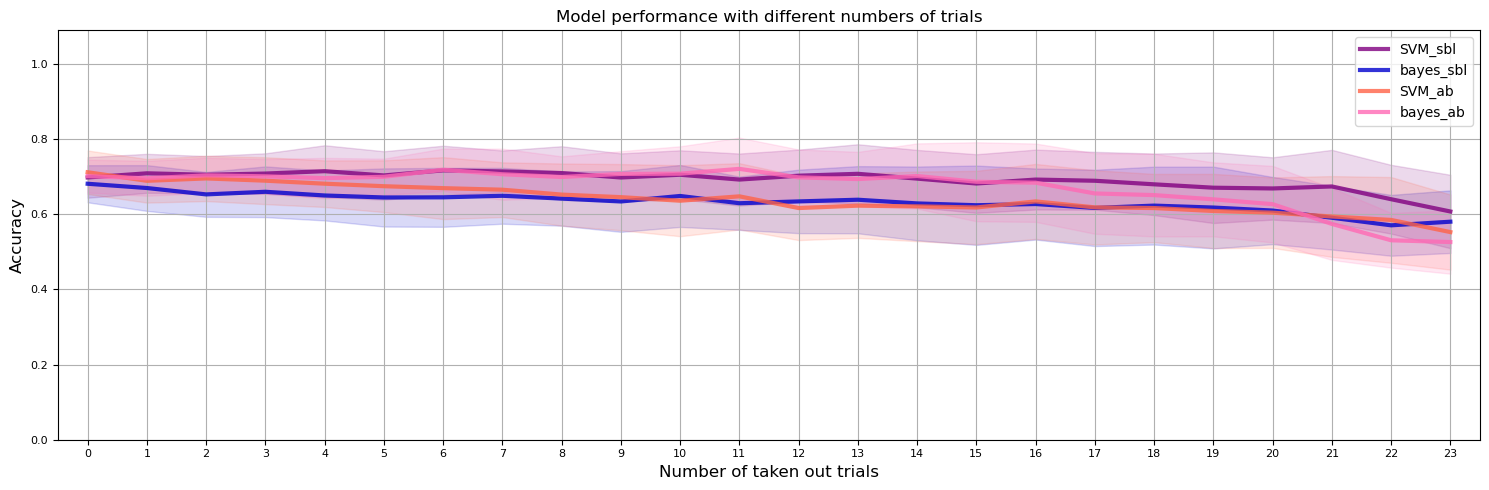

In [325]:
takeout_plot([tSVM_s_vs_bl, tbayes_s_vs_bl, tSVM_a_vs_b, tbayes_a_vs_b], 
              ['SVM_sbl', 'bayes_sbl', 'SVM_ab', 'bayes_ab'])